<a href="https://colab.research.google.com/github/comapi5/railway-route-finder/blob/main/calc_shortest_distance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx

print(nx.__version__)

3.1


## csv確認

In [5]:
station = pd.read_csv("station20230327free.csv")
station = station[["station_cd", "station_name", "lon", "lat"]]

print(station.shape)
station.head()

(10898, 4)


,station_cd,station_name,lon,lat
0,1110101,函館,140.726413,41.773709
1,1110102,五稜郭,140.733539,41.803557
2,1110103,桔梗,140.722952,41.846457
3,1110104,大中山,140.713580,41.864641
4,1110105,七飯,140.688556,41.886971


In [6]:
line = pd.read_csv("line20230327free.csv")
line = line[["line_cd", "line_name"]]

print(line.shape)
line.head()

(620, 2)


,line_cd,line_name
0,1001,中央新幹線
1,1002,東海道新幹線
2,1003,山陽新幹線
3,1004,東北新幹線
4,1005,上越新幹線


In [7]:
join = pd.read_csv("join20230327.csv")

print(join.shape)
join.head()

(10179, 3)


,line_cd,station_cd1,station_cd2
0,1002,100201,100202
1,1002,100202,100203
2,1002,100203,100204
3,1002,100204,100205
4,1002,100205,100206


## グラフネットワーク作成

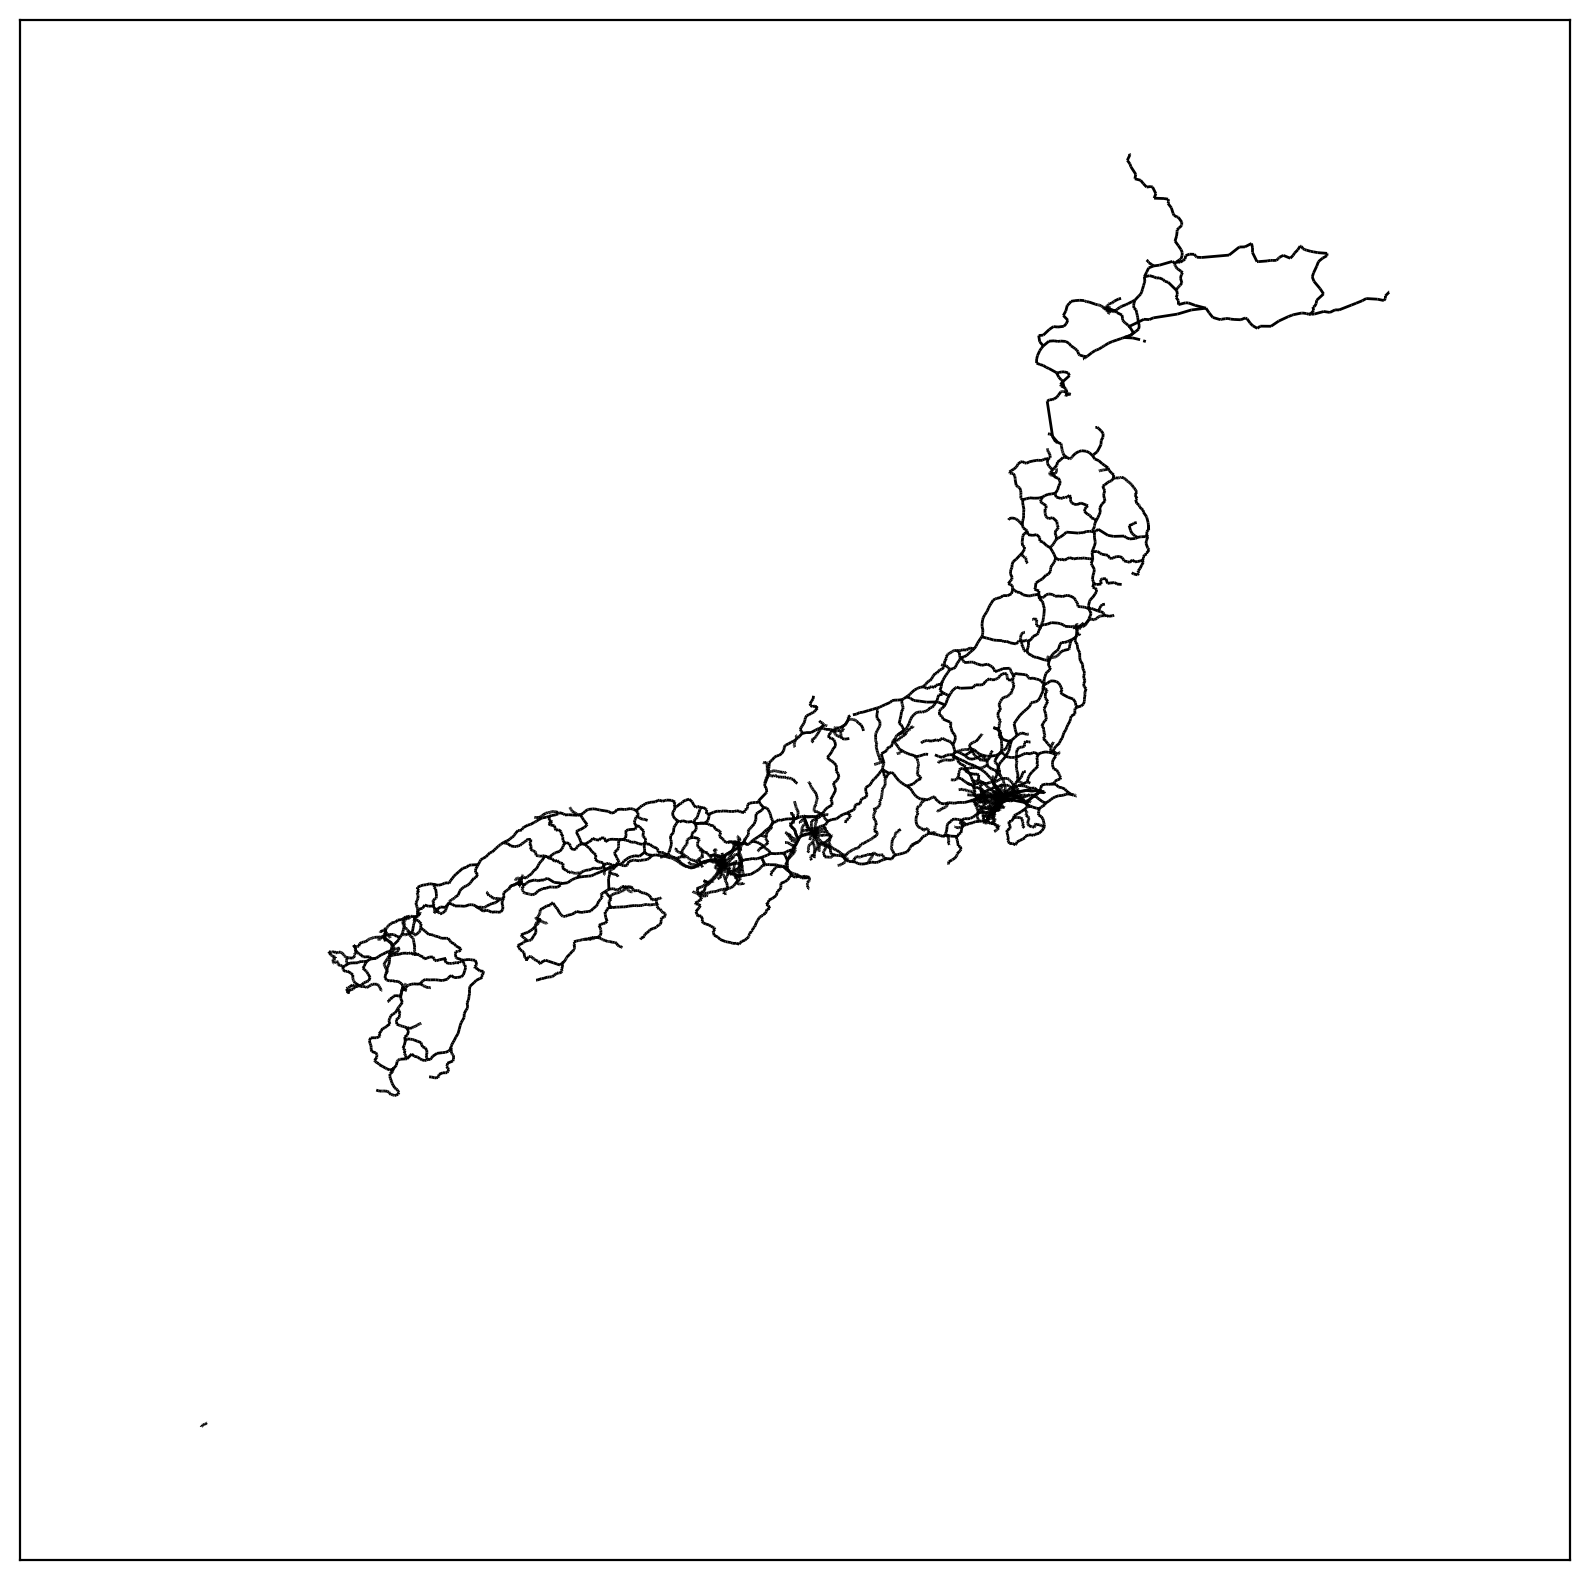

In [8]:
# station_cd1の緯度経度を追加
df = pd.merge(join, station.rename(columns={"station_cd": "station_cd1"}), on="station_cd1")
df = df.rename(columns={"lon": "lon_1", "lat": "lat_1"})

# station_cd2の緯度経度を追加
df = pd.merge(df, station.rename(columns={"station_cd": "station_cd2"}), on="station_cd2")
df = df.rename(columns={"lon": "lon_2", "lat": "lat_2"})

# 距離算出
dist = []
for r in df.iterrows():
  r = r[1]

  p_1 = np.array([r["lon_1"], r["lat_1"]])
  p_2 = np.array([r["lon_2"], r["lat_2"]])

  dist.append(np.linalg.norm(p_1 - p_2)) 

df["dist"] = dist

# グラフ作成
G = nx.Graph()
G.add_nodes_from(station["station_cd"])

pos = {}
for r in station[["station_cd", "lon", "lat"]].iterrows():
  i, j, k = r[1]
  pos[i] = (j, k)

for i, j, m in zip(df["station_cd1"], df["station_cd2"], df["dist"]):
  G.add_edge(i, j, weight=m)

## 同名の駅名でも路線ごとにcdが異なる
## 重み0として同名の駅を接続させる
for i, j, m in zip(station["station_name"], station["station_cd"], station["lat"]):
  for k, l, n in zip(station["station_name"], station["station_cd"], station["lat"]):
    if i == k and j != l and m == n:
      G.add_edge(j, l, weight=0)

# 可視化
plt.figure(figsize=(10, 10),dpi=200)
plt.axes().set_aspect('equal', 'datalim')
nx.draw_networkx(G, pos, alpha=0.0, with_labels=False)
nx.draw_networkx_edges(G, pos)
plt.show()

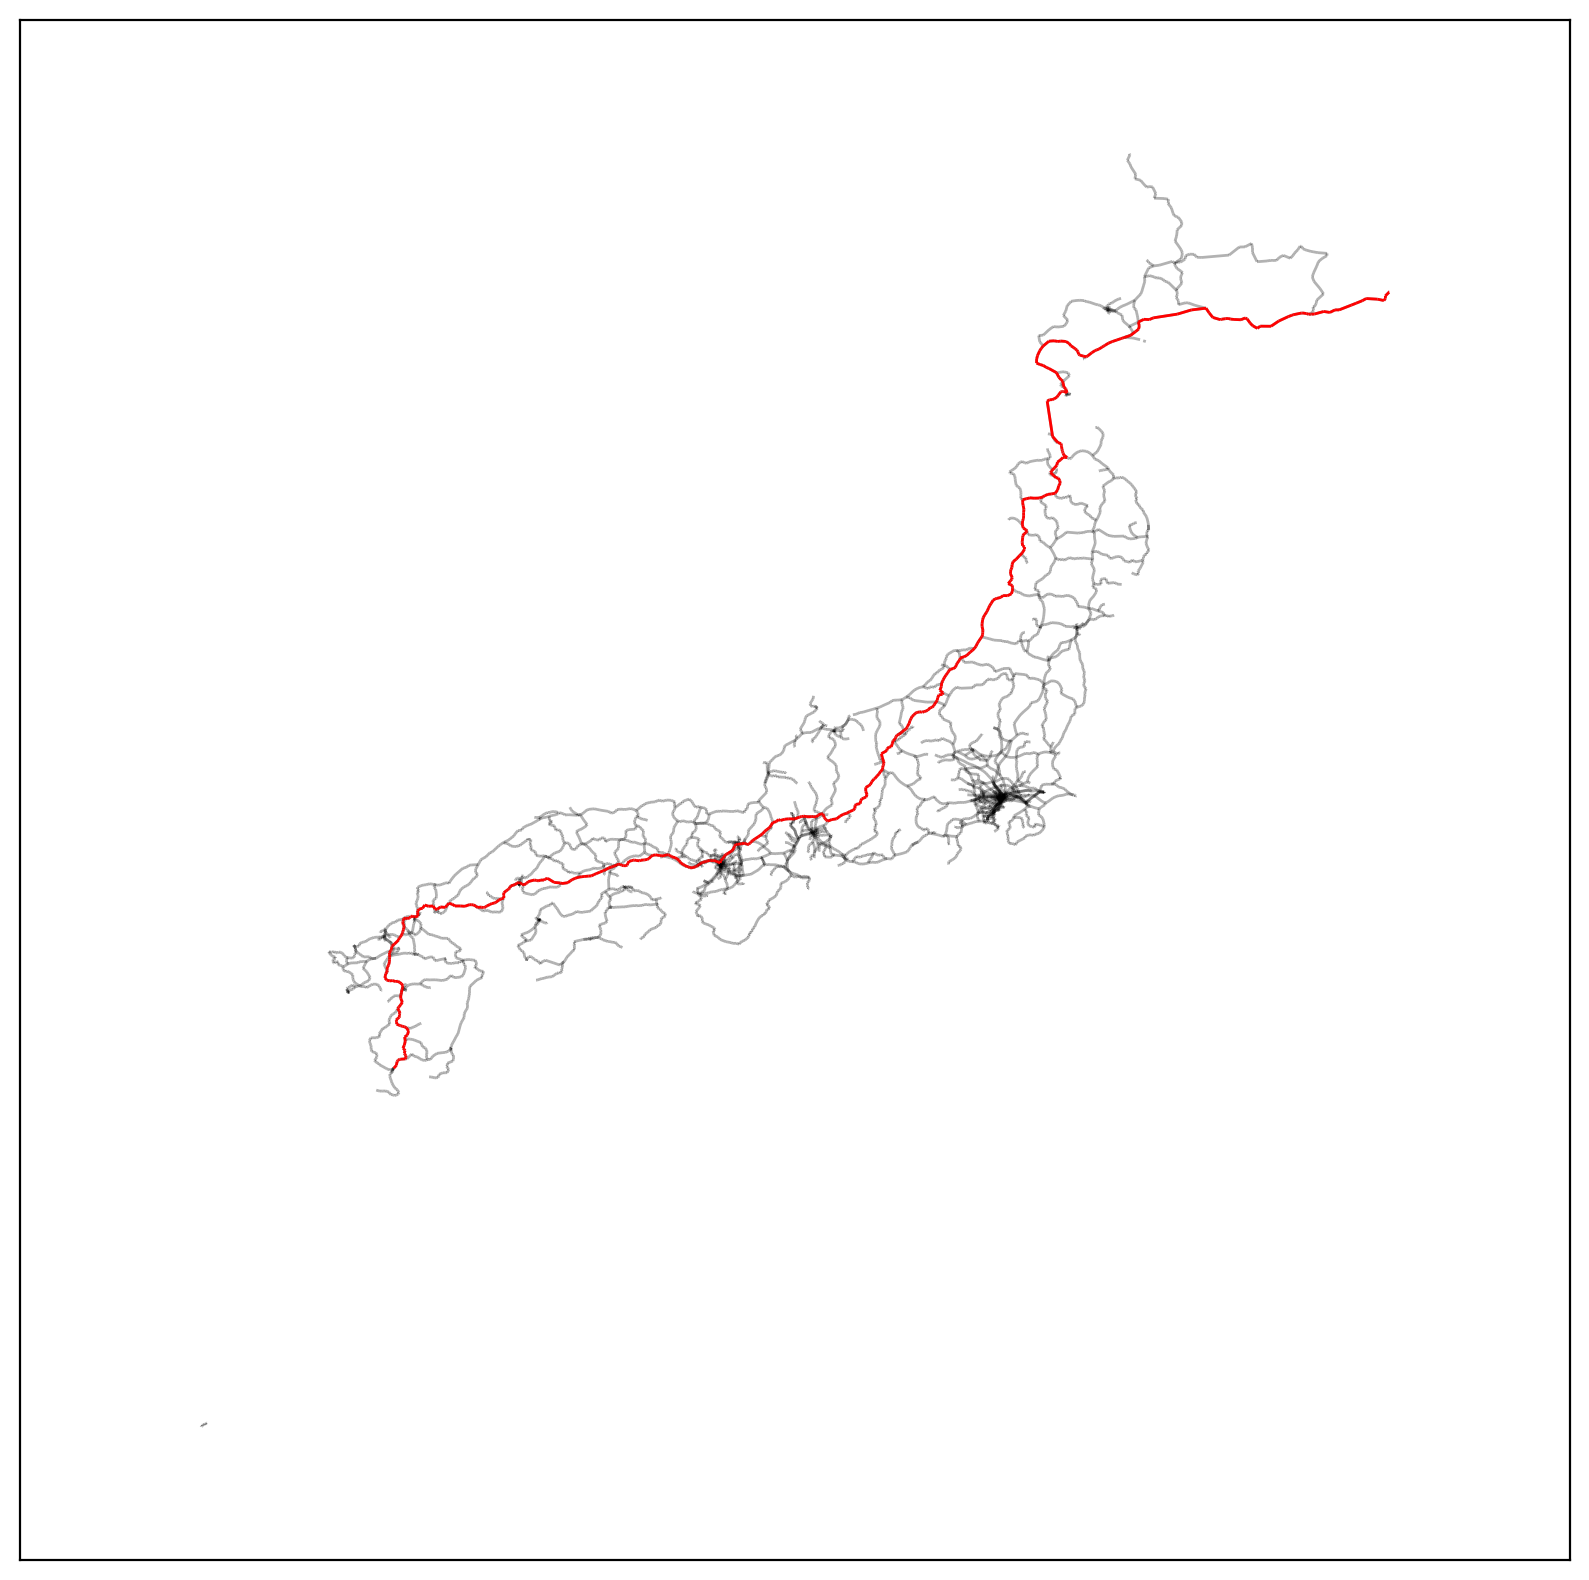

In [9]:
start = "根室"
end = "鹿児島"

# station_cd取得
start_cd = station[station["station_name"]==start]["station_cd"].values[0]
end_cd = station[station["station_name"]==end]["station_cd"].values[1]

# 最短経路取得
dij = nx.dijkstra_path(G, start_cd, end_cd)

# 可視化
G_root = nx.Graph()
G_root.add_nodes_from(dij)

pos_root = {}
for l in dij:
  for i, j, k in zip(station["station_cd"], station["lon"], station["lat"]):
    if l == i:
      pos_root[l] = (j, k)

for i in range(len(dij)-1):
  G_root.add_edge(dij[i], dij[i+1])


plt.figure(figsize=(10, 10),dpi=200)
plt.axes().set_aspect('equal', 'datalim')
nx.draw_networkx(G, pos, alpha=0.0, with_labels=False)
nx.draw_networkx_edges(G, pos, alpha=0.3)

nx.draw_networkx(G_root, pos_root, alpha=0.0, with_labels=False)
nx.draw_networkx_edges(G_root, pos_root, alpha=1.0, edge_color='r')
plt.show()